# 4) ML Project - Air Pollution - SkLearn ML Models

<font color='blue'> Scripts by Kevin Jeswani, Junaid Zafar, & Laiba Shah 
<br>
WeCloudData Bootcamp 2022 (Part-time Cohort)<br> </font>

First we take a look at a dataset for air pollutions deaths due over time for different countries. We visualize data and develop the linear regression models on the regional and national level. The linear regression models are valuable at predicting the general trend in deaths due over time and be used to predict future deaths, where past data appears to be highly linear. It has severe limitations for many countries. Polynomial models could be explored. To explore the interaction with other features, we proceed to merge different datasets between death due to environmental factors and socio-demographic/economic factors. We then examine them in 3 tree-based machine learning models.

The set of scripts in the folder 'AirPollution_Scripts' are segmented for the purpose of clarity & convenience <br>
The following is the suggested order for running the scripts:
- 'MLProject_AirPollution_Viz_LR.ipynb' - loading the initial Kaggle air pollution deaths dataset, processing, visualizing the base dataset, linear regression examination and future predictions.
- 'MLProject_DataProcessing_OECD_WB_GBD.ipynb'  - loading raw data from world bank and GBD/OECD datasets, cleaning, and merging usable data. We test the use of fuzzy data set merging.
- 'MLProject_Exploratory_ML_Models.ipynb' **This Script**- loading the cleaning & merged dataset, model selection with PyCaret, and discussion of models/insights in modelling data.
- 'MLProject_ML_Models_refined.ipynb' - development of selected machine learning models (Extra Trees, Random Forest, XGBoost), cross-validation, & Ensemble methods; discussion of model results

The aim is to explore the intial dataset (https://www.kaggle.com/datasets/akshat0giri/death-due-to-air-pollution-19902017?resource=download), supplement it, infer trends, and make predictions on future deaths due to environmental factors. 
The data is then supplement with:
- Global Burden of Disease Study 2019 Results via OECD.stats: https://stats.oecd.org/index.aspx?lang=en# (where the Kaggle dataset seems to have extracted and cleaned data from)
- World Bank Development Indicators: https://databank.worldbank.org/source/world-development-indicators#
<br>

## 1.0 Pre-processing

Steps to run SkLearn 1.2.2 in Conda virtual environment: <br>
- Open CMD.exe prompt in conda navigator <br>
- create a conda environment: conda create --name sklearn1_2_2 python=3.9.16 <br>
- activate conda environment: conda activate sklearn1_2_2 <br>
- install pycaret: pip install scikit-learn=1.2.2 <br>
- conda install ipykernel
- create notebook kernel: python -m ipykernel install --user --name sklearn1_2_2 --display-name "sklearn1_2_2" <br>
- Install other packages: pip install pandas, numexpr, plotly, seaborn, xgboost, matplotlib, icecream
<br>

### 1.1 Standard Imports

In [1]:
#check sklearn version
import sklearn
print(sklearn.__version__)

1.2.2


In [2]:
# Data Processing
import numpy as np #
from numpy import mean, std, absolute
import numexpr #numerical expression eval
import pandas as pd
import csv

# Plotting - Mat PlotLib & Seaborn
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
sns.set()

# Machine Learning - SkLearn
# Transformers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer,QuantileTransformer,Normalizer #data scaling
from sklearn.preprocessing import OrdinalEncoder # ordinal-categorical encoder
# Test-Train Split / Cross-Validation
from sklearn.model_selection import train_test_split, GroupKFold,StratifiedGroupKFold, RepeatedKFold, KFold #folds & splits
from sklearn.model_selection import cross_val_score, cross_validate, BaseCrossValidator, GridSearchCV #cross-valdation & gridsearch
# Models
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, VotingRegressor # Regressors + Blending Regressor
# Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error as MSE #Regression metrics
from sklearn.metrics import make_scorer, PredictionErrorDisplay #custom scoring function, plotting residuals
#Pipeline
from sklearn.pipeline import Pipeline
# Transformed target regressor
from sklearn.compose import TransformedTargetRegressor

# temp file for caching pipeline
from tempfile import mkdtemp

# XGBoost
from xgboost import XGBRegressor

## 2.0 Data Examination & Processing

In [3]:
# Input your local directories here - everything else is parametric
root = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts'
root_raw=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Raw Data'
root_proc=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Processed'
root_plots=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Plots'

### 2.1 Load Data into DF & Examine Contents

In [4]:
fid = '\MergedData_EnvDeaths_GDP_Pop_Income_SoDI_2.csv'
dtypes = {'Population':'float','GDP_pCapita':'float'} #specify data types as required
df_in = pd.read_csv(root_proc+fid,dtype=dtypes)
df_in=df_in.drop(['Unnamed: 0'],axis=1) #drop excess index column

#Display Properties
heading_properties = [('font-size', '10px')]
cell_properties = [('font-size', '10px')]

pd.set_option('display.max_rows', 100)  
df_in

,COU,Country,Year,Deaths_OZone,Deaths_PM2.5,Deaths_Indoor,Deaths_Handwashing,Deaths_Sanitation,Deaths_Water,Deaths_HighTemp,Deaths_LowTemp,GDP_pCapita,Population,Income_Class,SoDI
0,AFG,Afghanistan,2002,0.008418,0.069128,0.864084,0.154955,0.146771,0.195852,0.027761,7775.0,179.426579,22600774.0,L,0.194
1,AFG,Afghanistan,2003,0.007989,0.065408,0.801610,0.151253,0.144548,0.193319,0.025447,8358.0,190.683814,23680871.0,L,0.202
2,AFG,Afghanistan,2004,0.007311,0.060990,0.728383,0.138042,0.131303,0.176003,0.023667,7936.0,211.382074,24726689.0,L,0.209
3,AFG,Afghanistan,2005,0.006731,0.056720,0.657609,0.122056,0.114443,0.153736,0.020634,8244.0,242.031313,25654274.0,L,0.216
4,AFG,Afghanistan,2006,0.006097,0.054472,0.597933,0.107069,0.096464,0.129969,0.022527,7277.0,263.733602,26433058.0,L,0.224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707,ZWE,Zimbabwe,2015,0.002620,0.145930,0.546781,0.226782,0.150856,0.227201,0.020383,742.0,1445.069702,13814642.0,L,0.452
5708,ZWE,Zimbabwe,2016,0.002946,0.138328,0.526542,0.218186,0.142138,0.215595,0.023571,762.0,1464.588957,14030338.0,L,0.459
5709,ZWE,Zimbabwe,2017,0.003454,0.129761,0.506067,0.209739,0.135385,0.206877,0.008881,891.0,1235.189032,14236599.0,L,0.465
5710,ZWE,Zimbabwe,2018,0.003310,0.124713,0.485084,0.199204,0.125096,0.192489,0.013527,767.0,1254.642265,14438812.0,LM,0.471


### 2.2 Label Encoding of Categorical (Ordinal) Features

In [5]:
# Encore Ordinal Features before PyCaret to avoid dashboard mismatch issues
ordinal_features = ['Income_Class']
ordinal_encoder = OrdinalEncoder(categories=[['L', 'LM', 'UM', 'H']]) #Initialize encored on Income class col
df_in['Income_Class_encoded'] = ordinal_encoder.fit_transform(df_in[ordinal_features])

In [6]:
# Verify encoded column
df_in['Income_Class_encoded'].unique()

array([0., 1., 2., 3.])

### 2.3 Scale Numeric Features

In [7]:
# Train the model on the selected features to predict target air pollution deaths per 100,000
numeric_features=['Year','GDP_pCapita','Population','SoDI']

In [8]:
# Create new list of all features
features = numeric_features+['Income_Class_encoded']

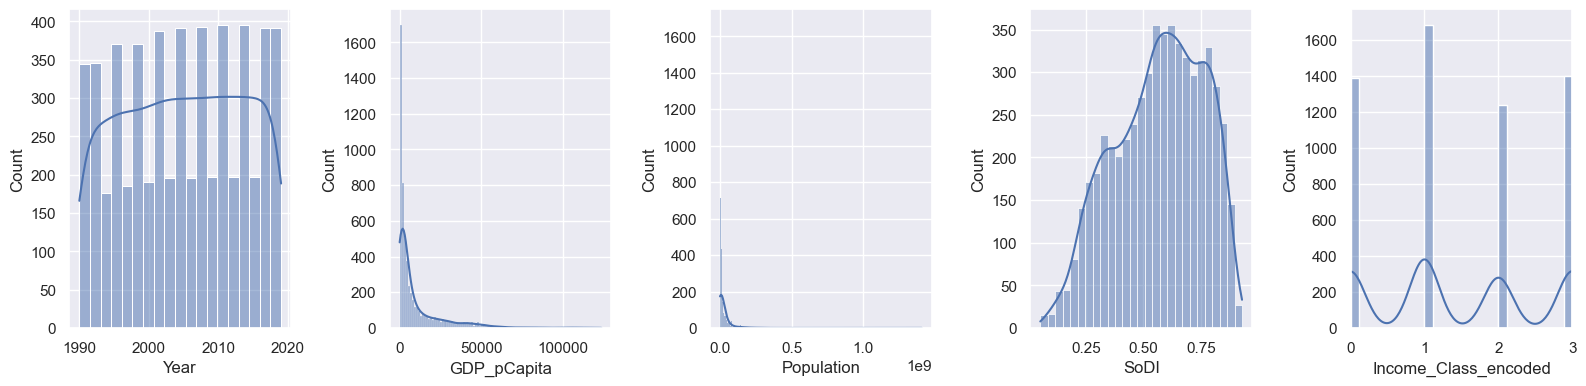

In [9]:
# Plot histograms of features to understand which scalers are appropriate
# Initialize subplots
fig, ax = plt.subplots(nrows=1, ncols = len(features), figsize=(16,4))
# for each subplot plot histogram
for i, feature in enumerate(features):
    sns.histplot(data=df_in,x=feature,ax=ax[i],kde=True) #use kernel density estimation to create smooth curve approximating distribution
    plt.xlim(0, df_in[feature].quantile(0.95)) #plot up to 95th percentile to avoid outliers for better viz
# Add more adding space between subplots
fig.tight_layout(pad=1.0)
# Display fig
plt.show()

Summary of SkLearn Scalers:
- StandardScaler - standarizes features by removing mean and scaling to uni variance. Works well with normally distributed data. This is a good default option.
- MinMaxScaler - scales to a fixed range (typ. [0,1]) Good when distribution is not Guassian, and to preserve data sparsity. Sensitive to outliers especially with large feautre range.
- RobustScaler - robust to outliers, removes median and scales data according to IQR. Good for data with outliers.
- MaxAbsScaler - scales to max abs val. appropriate for data centered at 0 and features have different scales
- PowerTransformer - corrects skeness and makes distribution more gaussian. Yeo-Johnson (defeault) (handles +/- vals) or box-cox (only positive vals)
- QuantileTransformer - makes data uniform or Gaussian by mapping to a quantile function, and mapping quantiles to uniform or gaussian distribution. Minimizes impact of outliers. <br>
<br>
As such:
- SoDI does need to be scaled given their distribution is not highly skewed and values are already [0,1]. <br>
- MinMaxScaler can be applied to the Year to simply change the magnitude of the values. Essentially this becomes a parameter that relates to change with increasing time magnitude.
- PowerTransformer will be applied to bother GDP_pCapita & Population due to their right skew

In [10]:
# Create new df of only features + Country Code
X_df = df_in[features+['COU']]
# Define Transformers
transformers = [('power', PowerTransformer(method='box-cox'), ['Population', 'GDP_pCapita']),
               ('standard', StandardScaler(), ['Year'])]
# Use ColumnTransformer to apply multiple transformers to multiple columns
X_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough') #remainder='passthrough' to keep all other columns
X_transformed = ColumnTransformer.fit_transform(X_transformer, X_df) #fit and transform

# Convert to df
X_df_transformed = pd.DataFrame(X_transformed, columns =features+['COU'])

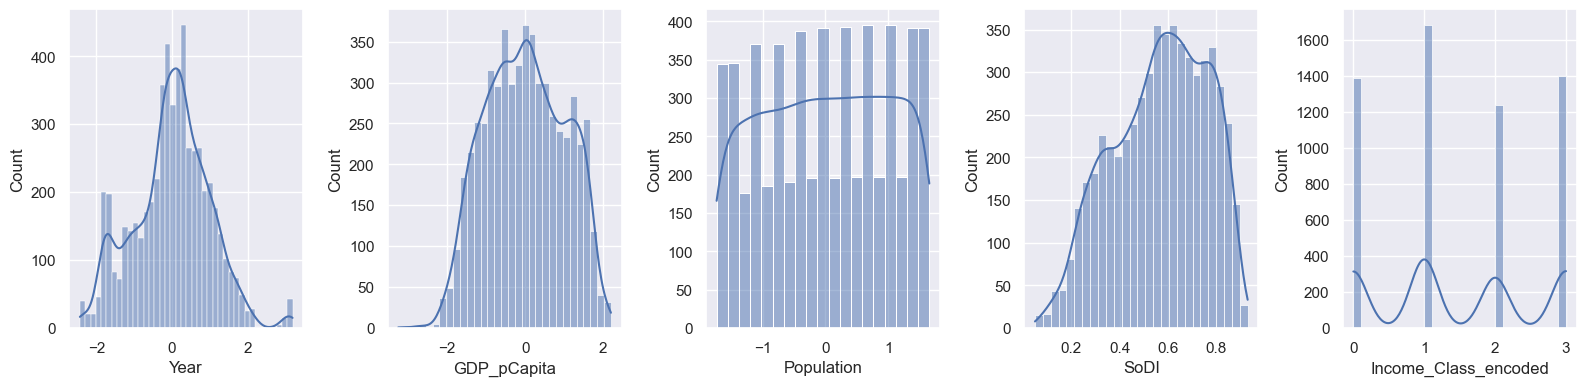

In [11]:
# Plot histograms of features to understand which scalers are appropriate
# Initialize subplots
fig, ax = plt.subplots(nrows=1, ncols = len(features), figsize=(16,4))
# for each subplot plot histogram
for i, feature in enumerate(features):
    sns.histplot(data=X_df_transformed,x=feature,ax=ax[i],kde=True) #use kernel density estimation to create smooth curve approximating distribution
# Add more adding space between subplots
fig.tight_layout(pad=1.0)
# Display fig
plt.show()

### 2.4 Scaling of Target Variables

The target variables do not typically need to be scaled unless the range is large or the scale of the values being predicted is very sensitive to scale

In [12]:
target_vars = ['Deaths_OZone','Deaths_PM2.5','Deaths_Indoor']

In [13]:
df_in[target_vars].describe()

,Deaths_OZone,Deaths_PM2.5,Deaths_Indoor
count,5712.000000,5712.000000,5712.000000
mean,0.146362,5.360815,7.849054
std,0.790284,17.362746,54.112946
min,0.000000,0.003234,0.000000
25%,0.001667,0.122347,0.011979
50%,0.006778,0.399815,0.261600
75%,0.031309,2.259193,1.686023
max,13.575265,229.067954,1385.598093


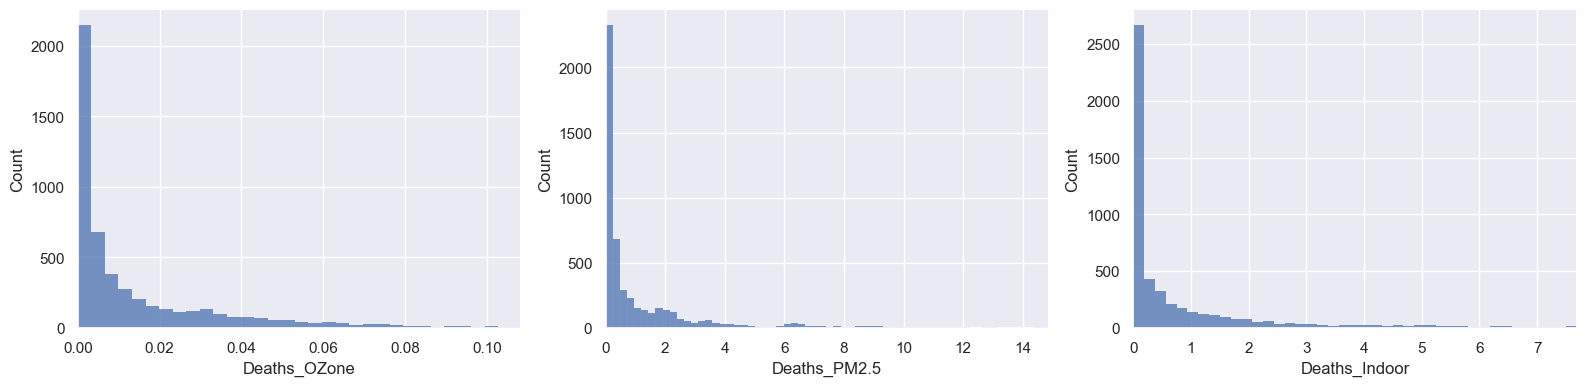

In [14]:
# Plot histograms of target variables to understand which scalers are appropriate
# Initialize subplots
fig, ax = plt.subplots(nrows=1, ncols = len(target_vars), figsize=(16,4))
# for each subplot plot histogram
for i, target in enumerate(target_vars):
    sns.histplot(data=df_in,x=target,ax=ax[i]) #use kernel density estimation to create smooth curve approximating distribution
    ax[i].set_xlim(0, df_in[target].quantile(0.90)) #plot up to 90th percentile to avoid outliers for better viz

# Add more adding space between subplots
fig.tight_layout(pad=1.0)
# Display fig
plt.show()

The target variables will be transformed using a log transformation, so that using MAPE as the primary evaluation metric will result in meaningful results. Without target transformations, the MAPE tends to infinity due to incredibly small actual values.

In [15]:
# Create a pipeline to transform the target variables
target_pipeline = Pipeline(steps=[
    ('sqrt_transform', FunctionTransformer(func=np.sqrt,inverse_func=np.square,
                                                validate=True)), #sqrt transformation, square inverse
    ('scale_transform', FunctionTransformer(func=lambda x: x * 100,inverse_func=lambda x: x / 100)) #scale up by 100
])


In [16]:
# Create a ColumnTransformer to pass target cols through pipeline
y_transformer = ColumnTransformer(transformers=[('target', target_pipeline, target_vars)], remainder='passthrough')

# Transform target variables
y_transformed = y_transformer.fit_transform(df_in[target_vars])
# Convert to df
y_df_transformed = pd.DataFrame(y_transformed, columns = target_vars) 

c:\Users\kevin\anaconda3\envs\sklearn1_2_2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


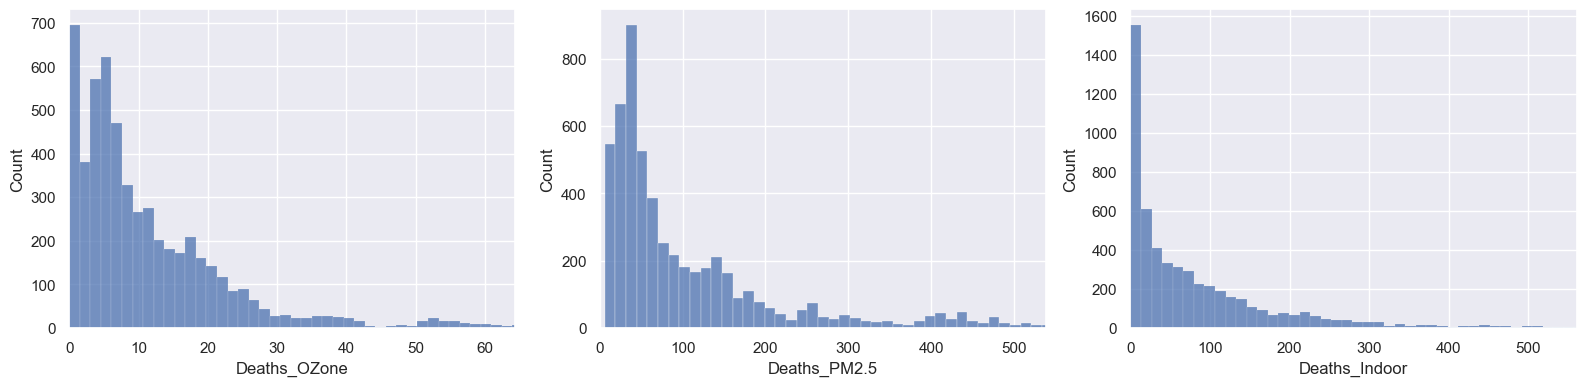

In [17]:
# Plot histograms of target variables to understand which scalers are appropriate
# Initialize subplots
fig, ax = plt.subplots(nrows=1, ncols = len(target_vars), figsize=(16,4))
# for each subplot plot histogram
for i, target in enumerate(target_vars):
    sns.histplot(data=y_df_transformed,x=target,ax=ax[i])
    ax[i].set_xlim(0, y_df_transformed[target].quantile(0.95)) #plot up to 90th percentile to avoid outliers for better viz
# Add more adding space between subplots
fig.tight_layout(pad=1.0)
# Display fig
plt.show()

In [18]:
y_df_transformed[y_df_transformed['Deaths_Indoor']==0]

,Deaths_OZone,Deaths_PM2.5,Deaths_Indoor
96,183.459309,550.377926,0.0
97,176.472664,529.417993,0.0
98,169.831188,537.053371,0.0
99,164.004330,518.627228,0.0
100,159.550705,504.543631,0.0
...,...,...,...
5394,11.924306,52.877186,0.0
5395,12.412115,54.271636,0.0
5396,12.866333,55.555593,0.0
5397,12.372980,56.937299,0.0


## 3.0 Simple Regression Modelling of Deaths due to Indoor Air Pollution with SkLearn

This section will go through the basics of using an SkLearn regressor, conduct hold-out validation, and then cross-validation. <br>
<br>
**Notes**: <br>
- Feature Scaling was experimented with but in the end, research online suggested that scaling is not necessary with tree-based regressors
- We will score all regressors by MAE = mean absolute error, but check R2, MAE, RMSE when doing cross validation and hold-out validation. MAE - penalizes for outliers less than MSE, MAPE is just the MAE expressed as a percentage of the actual value, but because many of the actuals are 0 or extremely low, this metric can become uninterpretable by tending to infinity.
- By Using SMAPE instead of MAPE, a more robust metric can be used in evaluating the models where values in the denominator tend to 0. It takes into account the magnitude of the actual and predicted values in computing the percentage error. However, when both values are 0, then it also results in undefined values. As such, a custom if mask function is inserted to mask and remove values  both elements on the index with a condition actuali=predictedi=0.
- A similar custom MAPE function is defined that uses a mask for when elements in the actuals array are 0
- We realized it was an added challenge to construction cross-validation folds while preserving the timeseries data. Thus, see Section 4.0.

### 3.1 Custom Regression Metrics Functions

In [19]:
# Create Custom RMSE Scoring Function
def rmse(actual, predicted):
    """
    Computes Root Mean Absolute Error (RMSE) between actual and predicted values
    Args:
        actual (array-like): Actual values
        predicted (array-like): Predicted values
    Returns:
        RMSE (float): Root Mean Absolute Error
    """
    # Calculcate RMSE = sqrt(mean(absolute difference between actual and predicted values squared))
    RMSE = np.sqrt(np.mean((actual - predicted)**2))
    return RMSE
# Create sklearn compatible scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [20]:
def mape_masked(actual,predicted,mask0=True):
    """
    Computes Mean Absolute Percentage Error (MAPE) between actual and predicted values, while excluding values that are divided by 0,
    which would result in infinite values
    Args:
        actual (array-like): Actual values
        predicted (array-like): Predicted values
    Returns:
        MAPE (float): Mean Absolute Percentage Error
    """
    if mask0:
        # Mask where actual values are not 0
        mask = np.where(actual != 0, True, False)
    else: #else create mask where all are True
        mask = np.ones_like(actual, dtype=bool)
    actual_masked = np.where(mask, actual, np.nan)  # Replace zeros with NaNs
    # Calculcate MAPE = mean(absolute difference between actual and predicted values divided by actual values)
    MAPE = np.divide(np.fabs(actual - predicted), actual_masked)[mask].mean()
    return MAPE
# Create sklearn compatible scorer
mape_scorer = make_scorer(mape_masked, greater_is_better=False)

In [21]:
# Define Custom SMAPE Scoring Function
def smape_masked(actual, predicted,mask0=True):
    """
    Computes Symmetric Mean Absolute Percentage Error (SMAPE) between actual and predicted values
    Args:
        actual (array-like): Actual values
        predicted (array-like): Predicted values
        mask0 (bool): Flag to mask 0 values in actual and predicted values
    Returns:
        SMAPE (float): Symmetric Mean Absolute Percentage Error    
    """
    # Calculate absolute difference and sum of actual and predicted values
    abs_diff = np.fabs(actual - predicted)
    sum_values = np.fabs(actual) + np.fabs(predicted)
    # If flag to mask 0 values is True
    if mask0:
        # Exclude elements where both abs_diff and sum_values are 0
        mask = (abs_diff == 0) & (sum_values == 0) # Create boolean mask where both elements on index are 0
        abs_diff = abs_diff[~mask] #mask out to exclude from calculation
        sum_values = sum_values[~mask]
    
    # Calculate SMAPE
    SMAPE = (2 * np.sum(abs_diff / sum_values)) / len(actual)
    return SMAPE
# Create sklearn compatible scorer
smape_scorer = make_scorer(smape_masked, greater_is_better=False)


In [22]:
# Define function to quickly evaluate model
def regression_metrics(actual,predicted):
    """
    Calculate R2 MAE MAPE, SMAPE, and RMSE for regression. This is a wrapper for the evaluation of the model
    Args:
        actual (array-like): Actual values
        predicted (array-like): Predicted values
    Returns: 
        [R2, MAE, MAPE,SMAPE, RMSE] Regression metrics as a list of 5 floats
    """
    # Evaluate the model
    R2 = round(r2_score(actual, predicted),2)
    MAE = round(mean_absolute_error(actual, predicted),2)
    MAPE = round(mape_masked(actual, predicted),2)
    SMAPE = round(smape_masked(actual, predicted),2)
    RMSE = round(rmse(actual, predicted),2)
    return [R2,MAE,MAPE,SMAPE,RMSE]

In [23]:
scores = ['r2','mae','mape','smape','rmse']

### 3.2 Splitting Strategy
-  Simple Train - Hold-out Test, using 30% testing of the total dataset
- Another constraint placed on the exercise will be to ensure that the full time-series of a country is kept within the same fold and either in the cross-validation group or in the hold-out testing set.
- Use the Country Code ('COU') identifier to split the data
- This will somewhat preserve timeseries data within the same grouping, It will still be mixed in with dozens of other time-series. <br>

In [24]:
#Create an array with the unique country codes
CountryCodes = X_df_transformed['COU'].unique() 

In [25]:
#Number of holdout-testing countries
n_holdout = int(len(CountryCodes)*0.30) #30% of countries 
# Randomly select countries for hold-out testing
c_holdout= np.random.choice(CountryCodes, size=n_holdout, replace=True)

In [26]:
# Cross-validation Train-Validate dataset
X_train = X_df_transformed[~X_df_transformed['COU'].isin(c_holdout)]

#Hold-out Testing dataset
X_test  = X_df_transformed[X_df_transformed['COU'].isin(c_holdout)]

### 3.3 Simple Random Forest Model

In [27]:
death = 'Deaths_Indoor'

In [28]:
# Determine the target variable of the dataset
y_train = y_df_transformed[~df_in['COU'].isin(c_holdout)].loc[:,[death]].to_numpy().ravel() #select the death metric being predicted, convert series to numpy and ravel to flatten array
y_test = y_df_transformed[df_in['COU'].isin(c_holdout)].loc[:,[death]].to_numpy().ravel()

Default Random Forest Model Parameters: <br>
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7671, verbose=0, warm_start=False)
                      <Br>
<br>
The following parameters will be changed:
- n_estimators = number of trees to build
- Criterion = MAE as MSE is more susceptible to outliers
- max_depth = 7 as we see that the number of levels in the tree did not need to be too large to 
- get decent results without overfitting
- If max_features=1.0,  max_features=n_features on regression problems - this is acceptable 
- n_jobs=-1 to run in parallel set to number of available cores

#### 3.2.1 Simple Train - Hold-out Testing

In [29]:
# Initialize the model
model = RandomForestRegressor(n_estimators = 100,
          criterion='absolute_error',max_depth=7, max_features=1.0,n_jobs=-1,random_state=123)

In [30]:
#Train model on training set
model_fit = model.fit(X_train[features], y_train)

In [41]:
# Feature Importance - display as df
f_importance = list(np.round(model.feature_importances_,2))
pd.DataFrame(f_importance,index=features,columns=['Feature Importance']).T

,Year,GDP_pCapita,Population,SoDI,Income_Class_encoded
Feature Importance,0.57,0.25,0.03,0.14,0.01


In comparison to the PyCaret models, the feature transformation of the Year causes there to be a much larger importance placed on the Year in predicted indoor air pollution deaths, with the next important feature being GDP per capita.

In [42]:
# Make predictions for test data
y_pred = model.predict(X_test[features])
# Get Regression metrics - display as df
r_metrics = regression_metrics(y_test,y_pred)
# Pass through inverse column transformer
y_test_inv = target_pipeline.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = target_pipeline.inverse_transform(y_pred.reshape(-1,1)).flatten()
r_metrics_inv = regression_metrics(y_test_inv,y_pred_inv)
pd.DataFrame([r_metrics,r_metrics_inv],index=['Metrics','Metrics_inv'],columns=scores)

,r2,mae,mape,smape,rmse
Metrics,0.77,39.05,0.47,0.37,90.74
Metrics_inv,-0.09,4.13,1.75,0.63,16.48


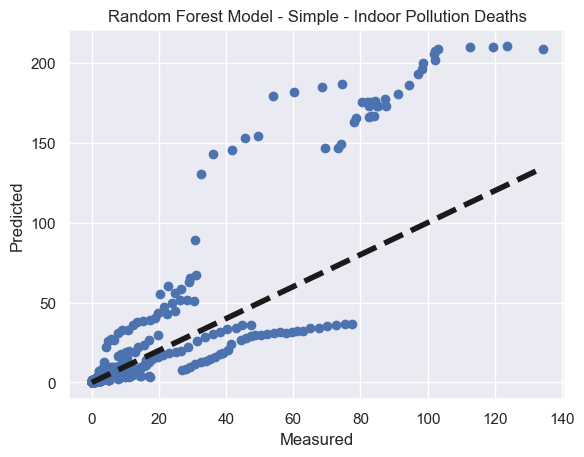

In [43]:
# Plotting predictions v. actuals for Random Forest Model
fig, ax = plt.subplots()
ax.scatter(y_test_inv, y_pred_inv)
ax.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Random Forest Model - Simple - Indoor Pollution Deaths')
plt.show()

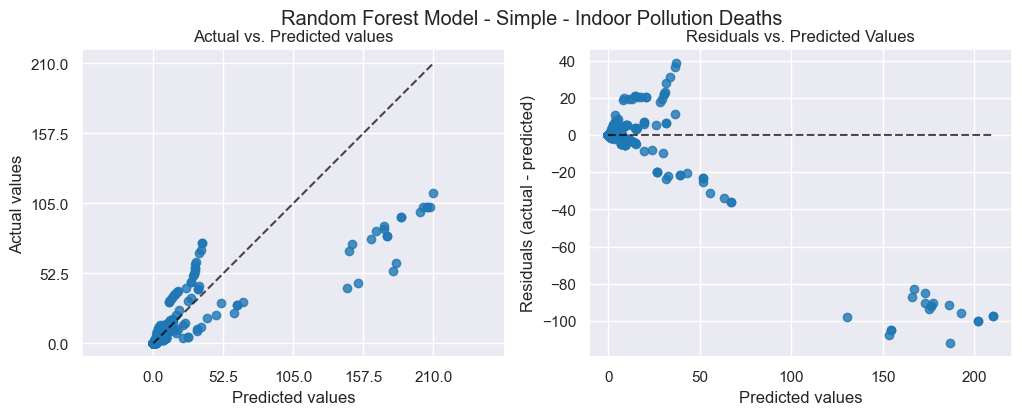

In [44]:
# New sklearn PredictionErrorDisplay can be used as well
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# Plot actual vs predicted
PredictionErrorDisplay.from_predictions(y_true=y_test_inv, y_pred=y_pred_inv,ax=axs[0],kind="actual_vs_predicted")
axs[0].set_title("Actual vs. Predicted values")
# Plot residual vs predicted
PredictionErrorDisplay.from_predictions(y_true=y_test_inv, y_pred=y_pred_inv,ax=axs[1],kind="residual_vs_predicted")
axs[1].set_title("Residuals vs. Predicted Values")
#axs[0].set_xlim([0,np.maximum(y_test_inv.max(), y_pred_inv.max())]) - does not seem to work to set lowerbound xlim
fig.suptitle('Random Forest Model - Simple - Indoor Pollution Deaths')
plt.show()

The preliminary model has a tendency to severely underpredicted or overpredict indoor air pollution deaths at the upper range of values.

#### 3.2.2 Cross-Validation - k-folds=10

Instead of hold-out validation, cross-validation can be conducted on the entire dataset.
- k=10 fold cross-validation (i.e. split into 10 subsets, where each subset will be the validation set exactly once)
- By using GroupKFold this continues with the group-preserving splitting strategy, where all elements for a country are put in the same fold.

In [45]:
# Use the full data set for cross-validation
y_cv = y_df_transformed[death].to_numpy().ravel()
X_cv = X_df_transformed

In [46]:
# define cross-validator (iterator)
cv = GroupKFold(n_splits=10) #10-fold cross-validation preserving groups
# evaluate model - only single metric permitted
cv_scores = cross_val_score(model, X_cv[features], y_cv, groups=X_cv['COU'],scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)

In [47]:
# Absolute values of neg MAE scores for 3x(10-fold CV)
# Note this is for the TRANSFORMED TARGET values
MAE_cv = ((np.fabs(cv_scores).mean())**2)/100
MAE_cv_std = ((np.fabs(cv_scores).std())**2)/100
print(f'MAE CV mean: {round(MAE_cv,2)}; MAE CV std: {round(MAE_cv_std,2)}')

MAE CV mean: 22.23; MAE CV std: 6.0


- The more general function cross_validate can to return multiple metrics.

In [48]:
# Create scoring dict to pass to cross_validate to examine multiple metrics
scoring = {'r2':'r2','mae':'neg_mean_absolute_error','mape':mape_scorer,'smape':smape_scorer,'rmse':'neg_root_mean_squared_error'}

In [49]:
# Use cross-validate function: display training score, pass 
cv_scores = cross_validate(model, X_cv[features], y_cv, scoring=scoring, groups=X_cv['COU'], cv=cv, n_jobs=-1,return_train_score=True) #return training results also

In [50]:
# Convert to df and display
pd.set_option('display.max_rows', 6)
scores_df = pd.DataFrame(cv_scores)
# Add a row for the mean of the scores_df
mean_row = pd.DataFrame(scores_df.mean(), columns=['mean']).T
scores_df = pd.concat([scores_df, mean_row])
# Set the index name to "mean"
scores_df.index = list(range(len(scores_df)-1)) + ['mean']
# Multiply columns by -1 based on substring for negative scoring metrics
neg_cols = scores_df.filter(regex='_mae$|_mape$|_smape$|_rmse$').columns
scores_df[neg_cols] = scores_df[neg_cols].mul(-1).round(2) #multiply by -1, round to 2 dec.
scores_df


,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_mape,train_mape,test_smape,train_smape,test_rmse,train_rmse
0,44.428783,0.644003,0.597634,0.982812,38.39,17.11,0.29,0.46,0.41,0.31,92.87,34.04
1,44.980772,0.241002,0.532439,0.984909,46.07,16.06,0.83,0.41,0.67,0.29,70.88,32.18
2,44.189780,0.858997,0.601806,0.975918,115.92,14.96,0.52,0.46,0.45,0.30,351.37,28.31
...,...,...,...,...,...,...,...,...,...,...,...,...
8,12.806040,0.102992,0.760797,0.985183,53.26,15.40,1.50,0.38,0.56,0.28,99.48,31.08
9,12.702038,0.116992,0.684808,0.974224,24.84,19.11,0.87,0.44,0.50,0.30,46.17,42.07
mean,38.091826,0.602201,0.646010,0.980048,47.15,17.07,0.70,0.44,0.48,0.30,109.48,34.98


Challenge with this approach are:
- The cross_validate results are for the transformed target and not the regression metrics on predicting actual target values

## 4.0 Tuning & Advanced Functiononality


This section will address some drawbacks experienced in the previous section.
- The focus will be to generalize the procedure and develop a pipeline
- The TransformedTargetRegressor can  be used instead of a ColumnTransformer that fits on an input target pipeline. Pipelines are meant to be used to transform features and not targets. 
- GridSearchCV will be conducted instead of a basic cross_validatate
- A blended model with other regressors will be built

### 4.1 Common Setup

#### 4.1.1 Metrics

In [51]:
# Initialize empty dict for outputs of cross-validation
output = {}

In [136]:
# Define features
features = ['Year','Population','GDP_pCapita','SoDI','Income_Class']

In [137]:
#Store Model Stats
scores_cols = ['train_'+m for m in scores] + ['test_'+m for m in scores] #add train/test prefix
metrics_cols = scores_cols + [f+'_importance' for f in features] #add feature importance metrics
df_modelstats = pd.DataFrame(metrics_cols) #create df with each row as a metric
df_modelstats.columns=['Metric'] #rename column

In [53]:
# Define scoring metrics for CV
scoring = {'r2':'r2','mae':'neg_mean_absolute_error','mape':mape_scorer,'smape':smape_scorer,'rmse':'neg_root_mean_squared_error'}

In [81]:
# Define function to extract metrics from cross_validate or GridSearchCV output
def cv_metrics(cv_output,neg_metrics=['mae','mape','smape','rmse']):
    '''
    Args:
        cv_output: output from cross_validate function or gridsearchcv; if estimator, results for best_estimator_ are extracted
        neg_metrics: list of metrics to extract from cv_output that are negative scoring metrics
    Returns:
        metrics_df: df of metrics for each fold and the mean; if GridSearchCV then only mean of best estimator is returned
    '''
    # If cv_output is a dict, it is the output from cross_validate
    if type(cv_output)==dict:
        cv_output_ = cv_output.copy()
        # Remove 'estimator' from ouput dict
        cv_output_.pop('estimator', None)   
        # Create a list of dfs for each estimator, each df is a row of feature importance
        metrics_df = pd.DataFrame(cv_output_)
        # Add a row for the mean of the scores_df
        mean_row = pd.DataFrame(metrics_df.mean(), columns=['mean']).T
        metrics_df = pd.concat([metrics_df, mean_row])
        # Set the index name to "mean"
        metrics_df.index = list(range(len(metrics_df)-1)) + ['mean']
        
    else: # Gridsearchcv estimator output
        # Convert full gridsearchcv results to df
        cv_results_df = pd.DataFrame(cv_output.cv_results_)
        # Get index of best estimator
        best_index = cv_output.best_index_
        # Remove all unnecessary columns to match any cross_validate output
        metrics_df = cv_results_df.loc[[best_index]].filter(regex='^(?!.*(split|param|std|rank)).*$')
        # Add mean as index and remove 'mean_' prefix in df
        metrics_df.columns = metrics_df.columns.str.replace('mean_','')
        metrics_df.index = ['mean']
    # Multiply columns by -1 based on substring for negative scoring metrics
    regex_pattern = '|'.join(['_{}$'.format(metric) for metric in neg_metrics]) #generate the pattern from input metrics
    neg_cols = metrics_df.filter(regex=regex_pattern).columns 

    metrics_df[neg_cols] = metrics_df[neg_cols].mul(-1).round(2) #multiply by -1

    return metrics_df

In [55]:
# Define function to extract feature importance from cross_validate output
def cv_featureimp(cv_output,features):
    '''
    Args:
        cv_output: output from cross_validate function or gridsearchcv; if estimator, results for best_estimator_ are extracted
        features: list of features used in the model
    Returns:
        feature_importances: df of feature importance for each estimator in the fold, and the mean
    '''
    # If cv_output is a dict, it is the output from cross_validate
    if type(cv_output)==dict:
        # Intiaize empty dfs list
        dfs = []
        # Get the estimator from the cross_validate output
        estimators = cv_output['estimator'] 
        try:
            # Create a list of dfs for each estimator, each df is a row of feature importance
            dfs = [pd.DataFrame(
                        estimator.regressor_.named_steps['regressor'].feature_importances_,  #locate the regressor in the pipeline, get the feature importance
                        index=features, columns=[idx]).T for idx, estimator in enumerate(estimators)]
        except:
            for idx,estimator in enumerate(estimators):
                for estimator_ in estimator.regressor_.estimators_:
                    #feats = estimator_.named_steps['regressor'].feature_importances_
                    feats = estimator_.named_steps['regressor'].feature_importances_
                    df = pd.DataFrame(feats, index=features, columns=[idx]).T
                    dfs.append(df)
                    
        # Concatenate all dataframes
        feature_importances = pd.concat(dfs, axis=0)
        # Add a row for the mean of the scores_df
        mean_row = pd.DataFrame(feature_importances.mean(), columns=['mean']).T
        feature_importances = pd.concat([feature_importances, mean_row])    
        
    # If cv_output is a GridSearchCV object, it is the output from GridSearchCV
    # Only best estimator is extracted
    else:
        feature_importances = pd.DataFrame(
                    cv_output.best_estimator_.regressor_.named_steps['regressor'].feature_importances_,  #locate the regressor in the pipeline, get the feature importance
                    index=features, columns=['mean']).T
                    
    return feature_importances

#### 4.1.2 Feature & Target Transformation

In [56]:
# Repeating some previously defined variables for clarity
# Create new df of only features + Country Code
X_df = df_in[features] 
# Define Transformers
transformers = [('power', PowerTransformer(method='box-cox'), ['Population', 'GDP_pCapita']),
               ('standard', StandardScaler(), ['Year']),
               ('ordinal', OrdinalEncoder(categories=[['L', 'LM', 'UM', 'H']]), ['Income_Class'])] #include ordinal in the feature transform pipeline
# Use ColumnTransformer to apply multiple transformers to multiple columns
X_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough') #passthrough to keep all other columns if exists

# Separate out the groups for custom CV = country coode
groups = df_in['COU']

In [57]:
def sqrt_transformer(y):
    return np.sqrt(y)*100
def sqrt_inv_transformer(y):
    return (y/100)**2

#### 4.2 GroupKFold vs. RepeatedKFold

This section will test results of using the group-preserving splitting strategy with GroupKFold vs. a standard KFold.

In [164]:
# Current Environmental Factor Death being predicted
death='Deaths_Indoor'
# Define model label
deathmodel='RF_Indoor_GroupKF'

In [59]:
# Separate target variable
y = df_in[death].to_numpy().ravel()

#Define primary regressor model
model = RandomForestRegressor(n_estimators = 100,criterion='absolute_error',max_depth=7, 
                                  max_features=1.0,n_jobs=-1,random_state=123)
# Set the cache for pipeline
cachedir = mkdtemp() 

# Define the features + main regressor pipeline
model_pipeline = Pipeline(steps=[('features', X_transformer),
                                ('regressor',model)],memory=cachedir) #cache the pipeline to temporary directory to inspect

# Define the transformed target regressor, pass the model pipeline and the target transformer
target_regressor = TransformedTargetRegressor(regressor=model_pipeline, func=sqrt_transformer, inverse_func=sqrt_inv_transformer)

# Define the cross-validator
cv = GroupKFold(n_splits=10) #10-fold cross-validation preserving groups

# Use cross-validate function: display training score, pass transformed target regressor pipeline
output[deathmodel] = cross_validate(estimator=target_regressor, X=X_df, y=y,  scoring=scoring, cv=cv, groups=groups,
                        n_jobs=-1,return_train_score=True,return_estimator=True)  #return training results, return the estimator fitted on the whole dataset
                        

In [165]:
# Extract feature importance of each fold
feature_importances = cv_featureimp(output[deathmodel] ,features)
# Extract metrics of each fold and mean; pass negative scoring metrics to multiply by -1
metrics_df = cv_metrics(output[deathmodel] ,neg_metrics=['mae','mape','smape','rmse'])
# Convert to df and display
pd.set_option('display.max_rows', 6)

In [61]:
metrics_df

,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_mape,train_mape,test_smape,train_smape,test_rmse,train_rmse
0,45.329006,0.102999,0.255356,0.992319,2.23,1.13,0.57,3.21,0.66,0.51,7.99,4.99
1,44.112020,1.102000,-1.142891,0.993299,1.80,1.06,3.95,2.49,1.01,0.49,4.68,4.67
2,41.675019,3.246005,0.246918,0.966830,29.54,0.77,1.61,3.77,0.77,0.48,139.07,3.14
...,...,...,...,...,...,...,...,...,...,...,...,...
8,11.891028,0.057000,0.572516,0.993128,3.53,0.99,25.12,2.08,0.84,0.47,10.02,4.71
9,11.889028,0.052999,0.373295,0.985748,0.68,1.51,6.35,3.68,0.81,0.48,2.17,6.80
mean,37.339219,1.175000,-0.054507,0.988512,5.49,1.15,5.10,3.25,0.76,0.49,22.53,5.13


In [166]:
# Store in model comparison df
df_modelstats[deathmodel] = metrics_df.loc['mean',scores_cols].tolist() + feature_importances.loc['mean',:].tolist()

Using the GroupKFold results in very inconsistent results on the test set for certain folds, wherein the average test MAE increases by over 4.75x(train MAE) and some folds result in a negative r2 score. It means that the the group KFold Stategy is not reliable when implemented through cross-validation, as compared to the simple hold-out validation.

In [167]:
deathmodel='RF_Indoor_KF'

In [67]:
# Conduct KFold CV
cv = RepeatedKFold(n_splits=10,n_repeats=2) #10-fold, with repeats

# Run CV
output[deathmodel] = cross_validate(estimator=target_regressor, X=X_df, y=y,  scoring=scoring, cv=cv,
                        n_jobs=-1,return_train_score=True,return_estimator=True)  #return training results, return the estimator fitted on the whole dataset

In [168]:
# Extract feature importance of each fold
feature_importances = cv_featureimp(output[deathmodel],features)
# Extract metrics of each fold and mean; pass negative scoring metrics to multiply by -1
metrics_df = cv_metrics(output[deathmodel],neg_metrics=['mae','mape','smape','rmse'])

In [69]:
metrics_df

,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_mape,train_mape,test_smape,train_smape,test_rmse,train_rmse
0,43.030240,1.964004,0.990710,0.988968,1.46,1.24,3.13,3.31,0.55,0.51,7.21,5.39
1,43.567243,1.463999,0.931038,0.988967,2.10,1.23,1.49,3.58,0.55,0.51,13.76,5.70
2,42.320236,2.551004,0.978616,0.983651,1.94,1.38,7.71,3.23,0.52,0.50,10.14,6.67
...,...,...,...,...,...,...,...,...,...,...,...,...
18,23.004049,0.711005,0.983902,0.983288,2.11,1.35,4.08,3.47,0.54,0.50,9.52,6.63
19,24.011572,0.098000,0.962822,0.987538,1.34,1.33,2.39,3.42,0.54,0.50,5.37,6.28
mean,40.190321,1.162154,0.964896,0.988903,1.57,1.26,3.89,3.44,0.55,0.50,7.56,5.67


In [169]:
# Store in model comparison df
df_modelstats[deathmodel] = metrics_df.loc['mean',scores_cols].tolist() + feature_importances.loc['mean',:].tolist()

Using a standard KFold performs better. In this manner the feature importance of macroeconomic indicators are effectively nation-independent. Feature importance is relatively stable through all the simple modeling exercises above.

### 4.3 GridSearch CV - Random Forest

In [170]:
deathmodel='RF_Indoor_tuned'

The same workflow can be used with a GridSearchCV to examine different tune modeling hyperparameters.

In [101]:
# Define Paramter Grid
# Regressor kwargs need to be accessed through the two layer regressor pipeline regressor__regressor__kwarg
# Similarly for the kwags of the feature transformers
param_grid = {'regressor__regressor__max_depth': [5,7,9],
                #'regressor__regressor__max_features': [0.5,0.75,1.0],  - #typical parameters to tune, not done here for succinctness based on PyCaret results
                #'regressor__regressor__n_estimators': [50,100,150],
                #'regressor__regressor__min_samples_split': [2,5,10],
                'regressor__regressor__min_samples_leaf': [1,2,5],
                'regressor__regressor__max_samples': [0.5,0.75,1.0],
                'regressor__features__power__method': ['box-cox', 'yeo-johnson']} #feature transformation

In [102]:
# Conduct KFold CV - no repeats to avoid computational expense
cv = RepeatedKFold(n_splits=10,n_repeats=2) #10-fold, with repeats

In [103]:
# Run GridSearchCV - returns the best estimator
output[deathmodel] = GridSearchCV(estimator=target_regressor, scoring=scoring, cv=cv, param_grid=param_grid,
                        n_jobs=-1,return_train_score=True,refit='mae',verbose=1).fit(X=X_df, y=y)
                          #return training results, return refitted best estimator

Fitting 20 folds for each of 54 candidates, totalling 1080 fits


In [171]:
# Extract feature importance for the best estimator
feature_importances = cv_featureimp(output[deathmodel],features)
# Extract metrics of mean of cv for best estimator
metrics_df = cv_metrics(output[deathmodel],neg_metrics=['mae','mape','smape','rmse'])

In [105]:
metrics_df

,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_mape,train_mape,test_smape,train_smape,test_rmse,train_rmse
mean,39.992802,4.756199,0.979354,0.996781,1.06,0.66,3.03,2.34,0.44,0.37,5.48,3.04


In [172]:
# Store in model comparison df
df_modelstats[deathmodel] = metrics_df.loc['mean',scores_cols].tolist() + feature_importances.loc['mean',:].tolist()

### 4.4 GridSearch CV - Extra Trees

Extra Trees Regressor implements the entire original dataset without replacement while Random Forest which subsamples the data with replacements <br>
Extra Trees randomly selects split location vs. Random Forest which chooses optimal split location.

Advantages of Extra Tree algorithm
- highly randomized choice of split location = lower variance = increase in speed
- Speed(Extra Trees) > Speed(Descision Tree | Random Forest)
- Reduced bias (reduced over- or under-fitting) <br>
<Br> <br>
Parameters:
- n_estimators = number of trees to build
- Criterion = gini (default) = function to measure quality of split
- max_depth = 7 as we see that the number of levels in the tree did not need to be too large to 
- get decent results without overfitting
- If max_features=1.0,  max_features=n_features on regression problems
- min_samples_split = number of samples required to split a node
- n_jobs=-1 to run in parallel set to number of available cores

In [107]:
# Define model label
deathmodel='XT_Indoor_tuned'
# Define the regressor
model = ExtraTreesRegressor(n_estimators = 100,
          criterion ='absolute_error',max_depth=7, max_features = 1.0,n_jobs=-1)
# Update pipeline
# Define the features + main regressor pipeline
model_pipeline = Pipeline(steps=[('features', X_transformer),
                                ('regressor',model)],memory=cachedir) #cache the pipeline to temporary directory to inspect

# Define the transformed target regressor
target_regressor = TransformedTargetRegressor(regressor=model_pipeline, func=sqrt_transformer, inverse_func=sqrt_inv_transformer)


The same workflow can be used with a GridSearchCV to examine different tune modeling hyperparameters.

In [108]:
# Define Paramter Grid
# Regressor kwargs need to be accessed through the two layer regressor pipeline regressor__regressor__kwarg
param_grid = {'regressor__regressor__max_depth': [5,7,9],
               'regressor__regressor__n_estimators': [50,100,150], 
                'regressor__regressor__min_samples_split': [2,5,10]}

In [109]:
# Run GridSearchCV
output[deathmodel] = GridSearchCV(estimator=target_regressor, scoring=scoring, cv=cv, param_grid=param_grid,
                        n_jobs=-1,return_train_score=True,refit='mae').fit(X=X_df, y=y)
                          #return training results, return refitted best estimator

In [174]:
# Extract feature importance for the best estimator
feature_importances = cv_featureimp(output[deathmodel],features)
# Extract metrics of mean of cv for best estimator
metrics_df = cv_metrics(output[deathmodel],neg_metrics=['mae','mape','smape','rmse'])

In [111]:
metrics_df

,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_mape,train_mape,test_smape,train_smape,test_rmse,train_rmse
mean,36.531201,4.431651,0.978694,0.99371,1.46,1.15,3.45,3.06,0.54,0.51,5.91,4.27


In [175]:
# Store in model comparison df
df_modelstats[deathmodel] = metrics_df.loc['mean',scores_cols].tolist() + feature_importances.loc['mean',:].tolist()

### 4.5 GridSearch CV - XGBoost

- XGBoost is somewhat imilar to the Extra Tree Regressor and Random Forest Regressor, but XGBoost is built on decision trees.
- XGBoost can use Random FOrest-like regressor as a base regressor, throught the XGBoost package, but it is different than Random Forest itself. 
- RandomForestRegressor in sklearn utilizes bagging (=bootstrap-aggregating), in essentially using multiple decision trees and combining predictions. 
- The XGRFRegressor is conducted through XGBoost gradient boosting. In this manner, trees are built sequentially and attempts are made to correct errors of the previous tree. <br>
<br>
Parameters:
- objective ='reg:squarederror' for regression problems
- booster by default is gbtree = tree-based model
- eta=learning_rate = 0.15, step-size shrinkage on the conservative side to prevent over-fitting
- max_depth = 7 to limit overfitting
- n_jobs=-1 to run in parallel set to number of available cores
- colsample_bytree = impacts number of features sampled for tree splitting

In [113]:
# Define model label
deathmodel='XGB_Indoor_tuned'
# Define the regressor
model = XGBRegressor(n_estimators = 100, objective ='reg:tweedie',
                    max_depth=7, learning_rate=0.15,
                    n_jobs=-1) 
# Update pipeline
# Define the features + main regressor pipeline
model_pipeline = Pipeline(steps=[('features', X_transformer),
                                ('regressor',model)],memory=cachedir) #cache the pipeline to temporary directory to inspect

# Define the transformed target regressor
target_regressor = TransformedTargetRegressor(regressor=model_pipeline, func=sqrt_transformer, inverse_func=sqrt_inv_transformer)


The same workflow can be used with a GridSearchCV to examine different tune modeling hyperparameters.

In [114]:
# Define the parameter grid for GridSearchCV
param_grid = {'regressor__regressor__learning_rate': [0.01,0.1,0.15],
             'regressor__regressor__max_depth': [5,7,9],
             'regressor__regressor__subsample': [0.5, 1],
             'regressor__regressor__colsample_bytree': [0.5, 1],
             'regressor__regressor__colsample_bylevel': [0.5, 1],
             'regressor__regressor__objective': ['reg:tweedie','reg:squarederror'],
        }

In [116]:
# Run GridSearchCV
output[deathmodel] = GridSearchCV(estimator=target_regressor, scoring=scoring, cv=cv, param_grid=param_grid,
                        return_train_score=True,refit='mae',n_jobs=-1).fit(X=X_df, y=y)
                          #return training results, return refitted best estimator

In [177]:
# Extract feature importance for the best estimator
feature_importances = cv_featureimp(output[deathmodel],features)
# Extract metrics of mean of cv for best estimator
metrics_df = cv_metrics(output[deathmodel],neg_metrics=['mae','mape','smape','rmse'])

In [119]:
metrics_df

,fit_time,score_time,test_r2,train_r2,test_mae,train_mae,test_mape,train_mape,test_smape,train_smape,test_rmse,train_rmse
mean,1.4178,0.019151,0.980731,0.999967,0.76,0.08,0.71,0.08,0.33,0.14,5.37,0.31


In [178]:
# Store in model comparison df
df_modelstats[deathmodel] = metrics_df.loc['mean',scores_cols].tolist() + feature_importances.loc['mean',:].tolist()

### 4.6 Ensembling (Blending) 3 Regression Models

In [179]:
deathmodel = 'voting'

In [122]:
# Examine best parameters for each model
output['RF_Indoor_tuned'].best_params_

{'regressor__features__power__method': 'box-cox',
 'regressor__regressor__max_depth': 9,
 'regressor__regressor__max_samples': 1.0,
 'regressor__regressor__min_samples_leaf': 1}

In [123]:
output['XT_Indoor_tuned'].best_params_

{'regressor__regressor__max_depth': 9,
 'regressor__regressor__min_samples_split': 2,
 'regressor__regressor__n_estimators': 150}

In [124]:
output['XGB_Indoor_tuned'].best_params_

{'regressor__regressor__colsample_bylevel': 1,
 'regressor__regressor__colsample_bytree': 1,
 'regressor__regressor__learning_rate': 0.15,
 'regressor__regressor__max_depth': 9,
 'regressor__regressor__objective': 'reg:tweedie',
 'regressor__regressor__subsample': 1}

In [125]:
# Define parameter dict for each model - slight modifications to the best parameters
rf_params = {'n_estimators': 150, 'max_depth':9,'min_samples_leaf':1,'min_samples_split':2,'max_features':1.0,'criterion':'absolute_error','bootstrap':True}
xt_params = {'n_estimators': 150, 'max_depth':9,'min_samples_leaf':1,'min_samples_split':2,'max_features':1.0,'criterion':'absolute_error'}
xgb_params = {'colsample_bylevel': 1, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'objective': 'reg:tweedie','subsample': 1}

In [127]:
# Define feature transformer & regressor pipelines - pass args
rf_pipeline = Pipeline(steps=[('features', X_transformer),('regressor',RandomForestRegressor(**rf_params))])
xt_pipeline = Pipeline(steps=[('features', X_transformer),('regressor',ExtraTreesRegressor(**xt_params))])
xgb_pipeline = Pipeline(steps=[('features', X_transformer),('regressor',XGBRegressor(**xgb_params))])

# Define voting regressor
voting_regressor = VotingRegressor(estimators=[('RF_Indoor_tuned', rf_pipeline), ('XT_Indoor_tuned', xt_pipeline),('XGB_Indoor_tuned', xgb_pipeline)])

# Define the TransformedTargetRegressor - pass voting regressor
voting_target_reg = TransformedTargetRegressor(regressor=voting_regressor,
                                                     func=sqrt_transformer,
                                                     inverse_func=sqrt_inv_transformer)
# Define a cross validator
cv = RepeatedKFold(n_splits=10,n_repeats=2) #10-fold CV - repeats = 2
# Run Cross Validation
output[deathmodel] = cross_validate(voting_target_reg, X=X_df, y=y, cv=cv, scoring=scoring, return_train_score=True,return_estimator=True)

In [180]:
# Get feature importance and metrics
feature_importances = cv_featureimp(output[deathmodel],features)
metrics_df = cv_metrics(output[deathmodel],neg_metrics=['mae','mape','smape','rmse'])


In [181]:
# Store in model comparison df
df_modelstats[deathmodel] = metrics_df.loc['mean',scores_cols].tolist() + feature_importances.loc['mean',:].tolist()

### 4.7 Model Evaluation

In [182]:
# Compare the model metrics
pd.set_option('display.max_rows', None)
df_modelstats

,Metric,RF_Indoor_GroupKF,RF_Indoor_KF,RF_Indoor_tuned,XT_Indoor_tuned,XGB_Indoor_tuned,voting
0,train_r2,0.988512,0.988903,0.996781,0.993710,0.999967,0.997665
1,train_mae,1.150000,1.260000,0.660000,1.150000,0.080000,0.680000
2,train_mape,3.250000,3.440000,2.340000,3.060000,0.080000,1.720000
3,train_smape,0.490000,0.500000,0.370000,0.510000,0.140000,0.390000
4,train_rmse,5.130000,5.670000,3.040000,4.270000,0.310000,2.600000
5,test_r2,-0.054507,0.964896,0.979354,0.978694,0.980731,0.981080
6,test_mae,5.490000,1.570000,1.060000,1.460000,0.760000,1.090000
7,test_mape,5.100000,3.890000,3.030000,3.450000,0.710000,2.480000
8,test_smape,0.760000,0.550000,0.440000,0.540000,0.330000,0.460000
9,test_rmse,22.530000,7.560000,5.480000,5.910000,5.370000,5.160000


A preliminary GridSearchCV exercise with a simple KFold = 10 revealed worse results than the initial cross_validate exercise with initial hyperparamters. This is in line with what occured in the PyCaret exercise. Some possible reasons:
- GridSearchCV may result in overfitted models that perform poorly on test sets.
- GridSearchCV conducts nested cross-validation, in which one layer of cv is used to selet the best hyperparamters for the next level of CV. This is a particular issue with small datasets such as this one.

However, when RepeatedKFold was used as with the simple cross_validate runs, similar model accuracies were determined.

In [198]:
# Define plotting paramters
plot_groups = [('test_r2','train_r2'),('test_mae','train_mae'),('test_mape','train_mape'),
                ('test_smape','train_smape'),('test_rmse','train_rmse'),
                ('Year_importance','GDP_pCapita_importance','Population_importance','SoDI_importance','Income_class_importance')]
plot_titles = ['R2','MAE','MAPE','SMAPE','RMSE','Feature Importance']
plot_models = df_modelstats.columns.tolist()
plot_models.remove('Metric')

# Reset index as the metric
plot_df = df_modelstats.copy().set_index('Metric').stack().reset_index()
plot_df.columns = ['Metric','Model','Value']

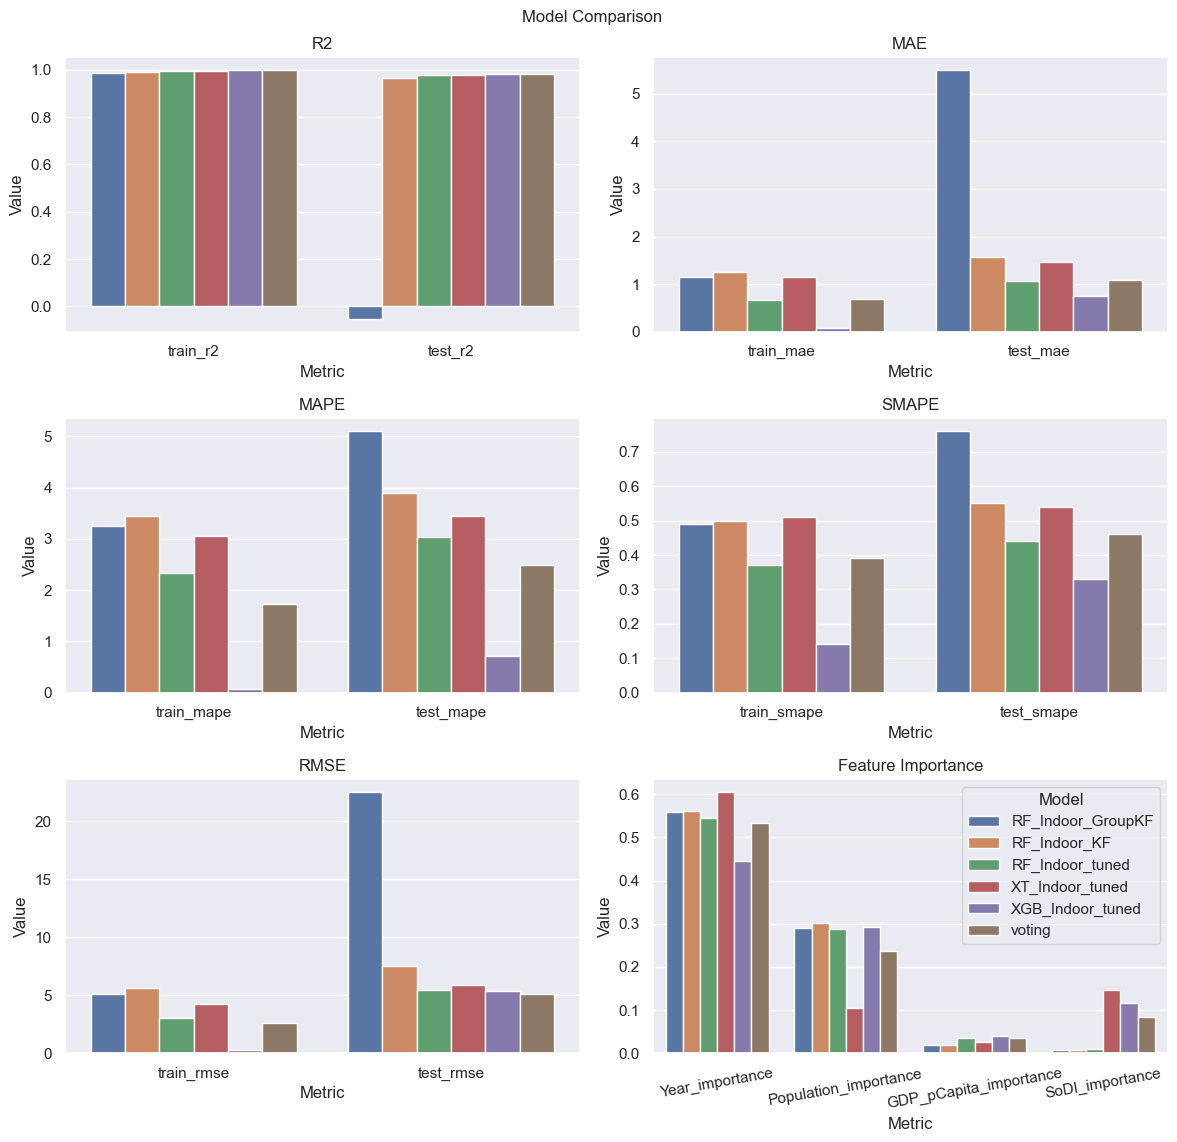

In [223]:
# Create the subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12)) #3 rows, 2 columns
# convert 2d axes array to 1d array - easier to iterate
axes = axes.flatten()
# Set overarching title
fig.suptitle('Model Comparison', fontsize=12)
# Iterate through each subplot group
for idx, (group, ax) in enumerate(zip(plot_groups, axes)): #zip to iterate through 2 lists at once; enumerate to access index too
    # Filter data based on the metrics in the group
    filtered_data = plot_df[plot_df['Metric'].isin(group)]
    # Create a clustered bar plot using seaborn
    sns.barplot(x='Metric', y='Value', hue='Model', data=filtered_data, ax=ax)
    # Set the title for each subplot
    ax.set_title(plot_titles[idx])

    # Remove the legend except for the last plot
    if idx != len(plot_groups) - 1:
        ax.get_legend().remove()
    
    # Rotate x-axis labels if they have more than 12 characters
    for tick in ax.get_xticklabels():
        if len(tick.get_text()) > 12:
            tick.set_rotation(10)

# Remove the unused subplot (if any)
if len(plot_groups) < len(axes):
    axes[-1].axis('off')

# Tight Layout and render
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


Observations <br>
- The tree regressors have similar performance and the voting method doesn't produce a model that is significantly better than any of the 3 individual models. However it could prove to be more robust.
- These models can still offer some insight into the interaction of the socio-demographic/economic metrics and the deaths.
- Linear regression can be used alongside this as it preserves time-series relationships and can predict trends on a national or regional level, whereas the tree-based regressors link other other endogenous variables to environmental deaths. 
- XGB may be overfitting on the train data, as evidenced by the almost 0 RSE, MAPE, MAE, but also has better test MAE and MAPE than the other regressors. 
All have strong R2 test & train values with the exception of the group K-fold model, which performs poorly on the test sets.